In [10]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None # default='warn'
import os
import re
import string
import nltk
import datetime as dt
from termcolor import colored
from statistics import mean
from tqdm.notebook import tqdm,tnrange
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as SIA_VADER
from nltk.sentiment import SentimentIntensityAnalyzer as SIA_NLTK
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import researchpy as rp
import scipy.stats as stats
sns.set_style('darkgrid')
sns.set_context('paper')
style.use('ggplot')
matplotlib.rcParams['font.family'] = 'helvetica'
matplotlib.rcParams['figure.titlesize'] = 'large'
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

In [11]:
def import_submissions():
    path = './submissions_scraped/'
    files = []
    for filename in os.listdir(path):
        files.append(pd.read_csv(os.path.join(path, filename)))
    
    files = pd.concat(files)
    df_submissions = pd.DataFrame(files)
    df_submissions.drop(columns=['Unnamed: 0'], inplace=True)
    df_submissions.dropna(inplace=True)
    return df_submissions

def import_submissions_previous():
    path = './submissions_scraped_previous/'
    files = []
    for filename in os.listdir(path):
        files.append(pd.read_csv(os.path.join(path, filename)))
    
    files = pd.concat(files)
    df_submissions = pd.DataFrame(files)
    df_submissions.drop(columns=['Unnamed: 0'], inplace=True)
    return df_submissions

def import_comments():
    df_comments = pd.read_csv('./comments_scraped/comments.csv')
    df_comments.drop(columns=['Unnamed: 0'], inplace=True)
    df_comments.dropna(inplace=True)
    return df_comments

def import_comments_previous():
    df_comments = pd.read_csv('./comments_scraped_previous/comments.csv')
    df_comments.drop(columns=['Unnamed: 0'], inplace=True)
    return df_comments

def clean_text(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    text = re.sub('^\[removed\]|^\[deleted\]', '', str(text))
    text = re.sub('^\[deleted by user\]', '', str(text))
    text = re.sub('^nan', '', str(text))
    text = re.sub(r'#', '', str(text))
    text = re.sub(r"(?:\@|https?\://)\S+", "", str(text))
    text = re.sub(r'[^\x00-\x7f]',r'', str(text))
    text = re.sub(r'www\S+', '', str(text))
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

def is_positive(compound):
    if compound > 0.05:
        return 1
    elif compound < -0.05:
        return -1
    else:
        return 0

def convert_label(text):
    if text == 'pos':
        return 1
    elif text == 'neg':
        return -1
    else:
        return 0

In [12]:
subreddits = ['CrohnsDisease', 'IBD', 'UlcerativeColitis', 'ibs']
colors = ['#cc5a49', '#4586ac', '#9e97cc', '#777777']

# Data before 12-2020
df_sub_prev = import_submissions_previous()
df_comm_prev = import_comments_previous()

# Data after 12-2020
df_sub_aft = import_submissions()
df_comm_aft = import_comments()

df_submissions = pd.concat([df_sub_prev, df_sub_aft])
df_comments = pd.concat([df_comm_prev, df_comm_aft])

df_submissions['title_and_body'] = df_submissions['title'] + ' ' + df_submissions['body']
df_submissions['title_and_body'] = df_submissions['title_and_body'].apply(lambda x: clean_text(str(x)))
df_comments['body'] = df_comments.body.apply(lambda x: clean_text(str(x)))

df_submissions = df_submissions[df_submissions['title_and_body'] != '']
df_comments = df_comments[df_comments['body'] != '']

df_submissions['created'] = pd.to_datetime(df_submissions['created'])
df_comments['created'] = pd.to_datetime(df_comments['created'])
df_comments = df_comments[df_comments['created'] < dt.datetime(2022, 10, 1)]

In [13]:
sia_vader = SIA_VADER()
roberta = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)
labels = ['neg', 'neu', 'pos']

In [14]:
sentiments = []
compounds = []
for post in tqdm(df_submissions.title_and_body, desc='Analyzing with vader'):
    scores = sia_vader.polarity_scores(post)
    sentiments.append(sia_vader.polarity_scores(post))
    compounds.append(scores['compound'])

df_submissions['sia_vader'] = sentiments
df_submissions['compound'] = compounds

Analyzing with vader:   0%|          | 0/82471 [00:00<?, ?it/s]

In [15]:
df_submissions.created = df_submissions.created.apply(lambda x: x.strftime('%y-%m'))

In [16]:
df_submissions = df_submissions[df_submissions['created'] != '21-02']
df_submissions = df_submissions[df_submissions['created'] != '21-03']
df_submissions = df_submissions[df_submissions['created'] != '21-04']

### Performing Kolmogorov‑Smirnov one tailed test

By setting **alternative=greater**꞉

Null hypothesis is that F(x) <= G(x) for all x; the alternative is that F(x) > G(x) for at least one x.

### Test 1꞉ Submission count꞉
**before pandemic vs after pandemic**

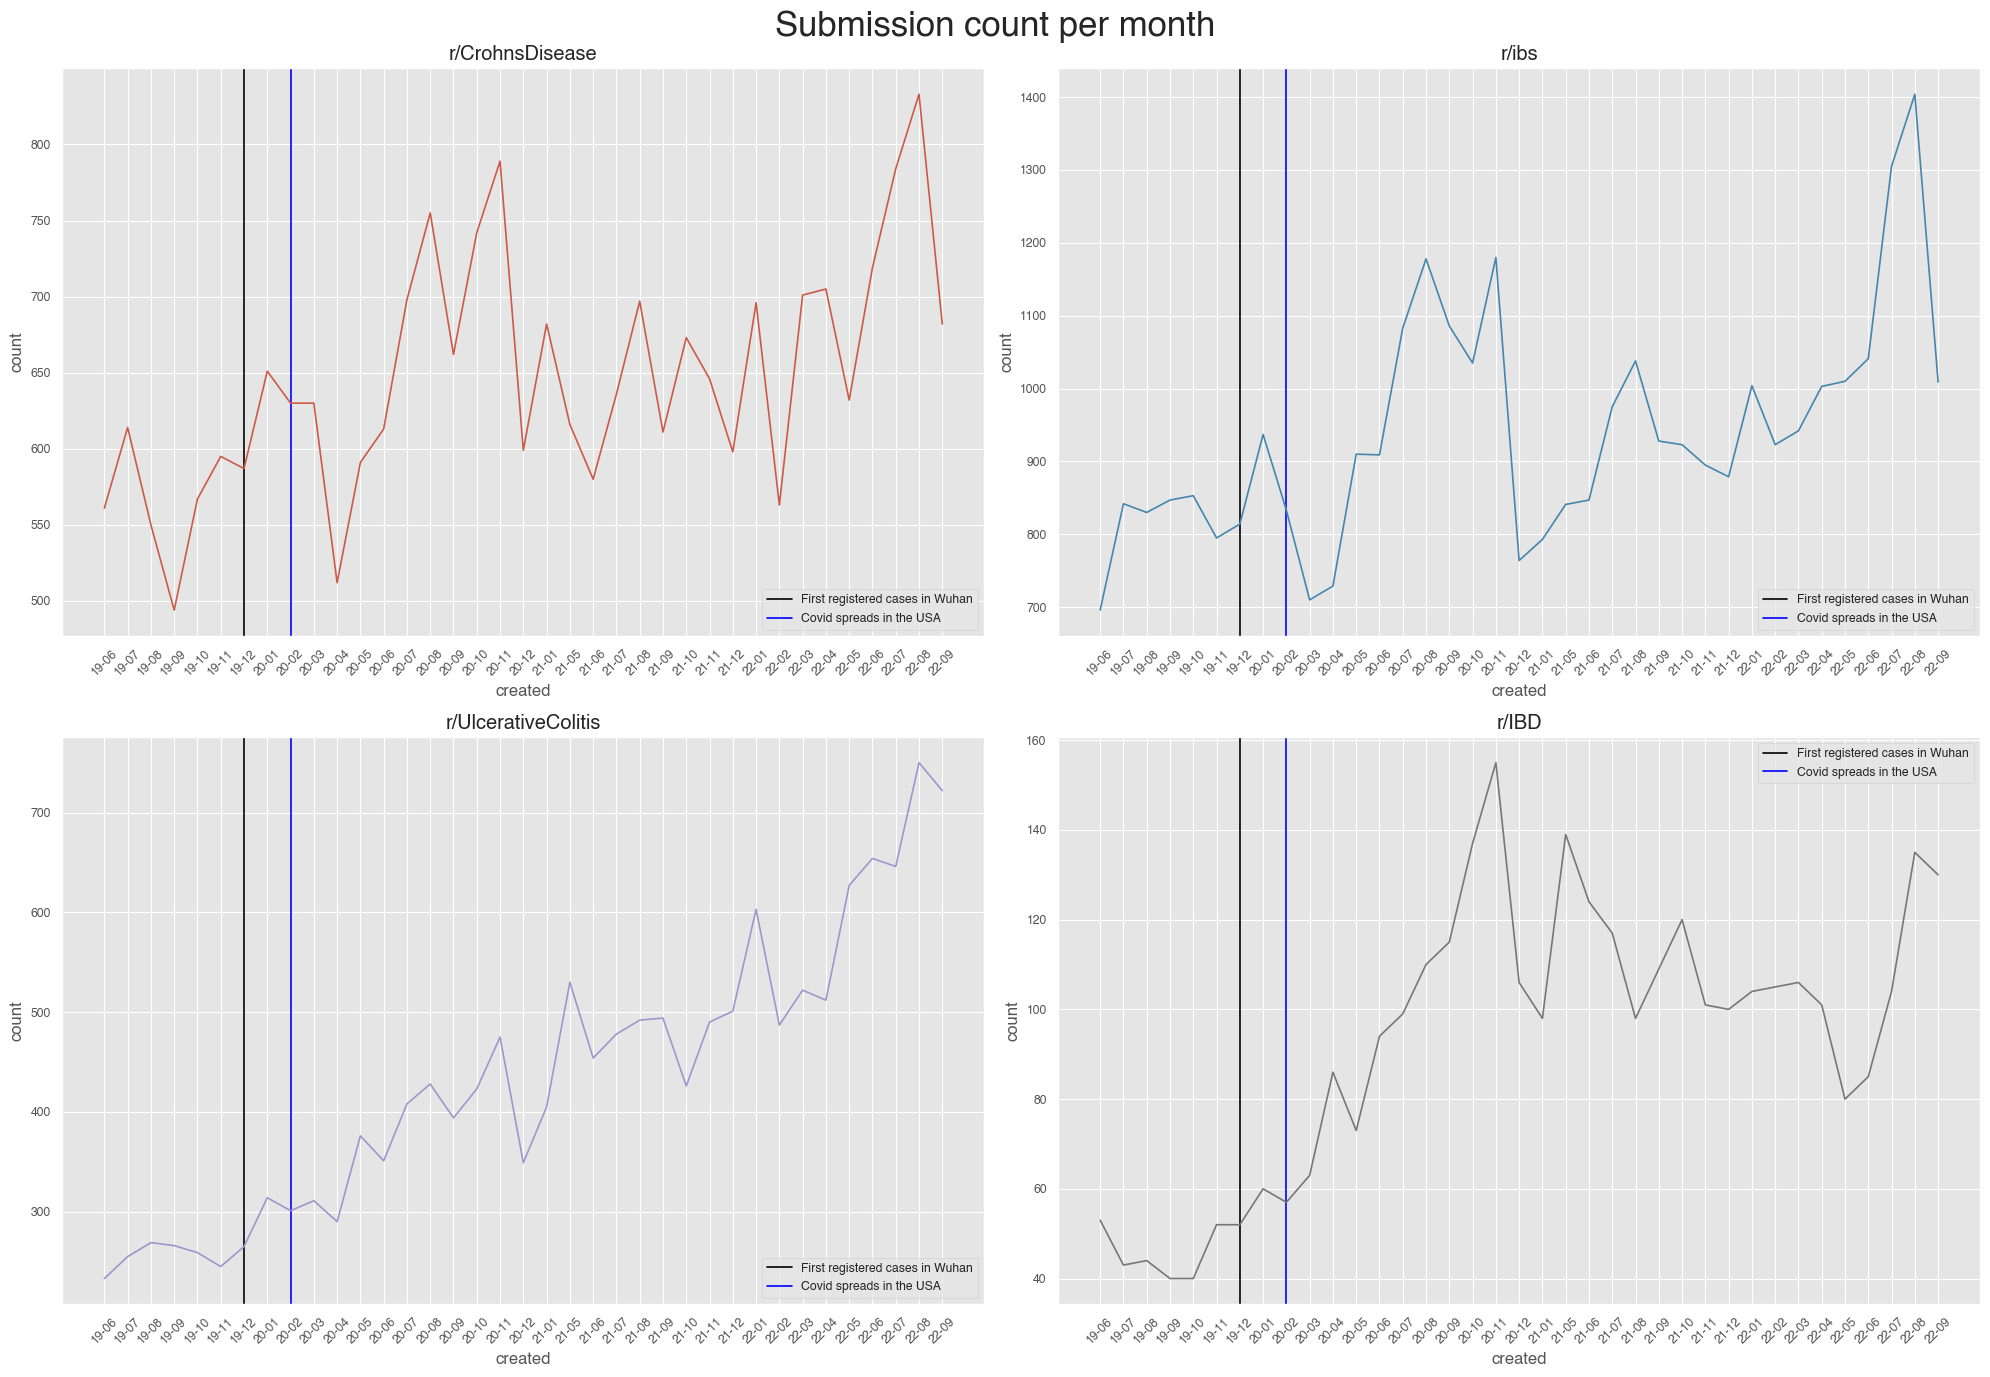

In [17]:
df_subs_per_month = df_submissions.groupby(['created', 'subreddit']).count().reset_index()

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20,14), nrows=2, ncols=2)

plt.suptitle('Submission count per month', fontsize=25)

ax1.set_title('r/CrohnsDisease')
cr = df_subs_per_month[df_subs_per_month['subreddit'] == 'CrohnsDisease']
ax1.set_ylabel('count')
ax1.axvline(6, color='black', label='First registered cases in Wuhan')
ax1.axvline(8, color='blue', label='Covid spreads in the USA')

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
sns.lineplot(x=cr.created, y=cr.id, ax=ax1, color=colors[0])

ax2.set_title('r/ibs')
ibs = df_subs_per_month[df_subs_per_month['subreddit'] == 'ibs']
ax2.set_ylabel('count')
ax2.axvline(6, color='black', label='First registered cases in Wuhan')
ax2.axvline(8, color='blue', label='Covid spreads in the USA')

plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
sns.lineplot(x=ibs.created, y=ibs.id, ax=ax2, color=colors[1])

ax3.set_title('r/UlcerativeColitis')
ulc = df_subs_per_month[df_subs_per_month['subreddit'] == 'UlcerativeColitis']
ax3.set_ylabel('count')
ax3.axvline(6, color='black', label='First registered cases in Wuhan')
ax3.axvline(8, color='blue', label='Covid spreads in the USA')

plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
sns.lineplot(x=ulc.created, y=ulc.id, ax=ax3, color=colors[2])

ax4.set_title('r/IBD')
ibd = df_subs_per_month[df_subs_per_month['subreddit'] == 'IBD']
ax4.set_ylabel('count')
ax4.axvline(6, color='black', label='First registered cases in Wuhan')
ax4.axvline(8, color='blue', label='Covid spreads in the USA')

plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
sns.lineplot(x=ibd.created, y=ibd.id, ax=ax4, color=colors[3])

plt.legend()
plt.tight_layout()
plt.show();

In [18]:
df_sub_counts = df_submissions.groupby(['created', 'subreddit']).count().reset_index()

p_values = []
statistics = []
dfs = []
for sr in subreddits:
    a = df_sub_counts[(df_sub_counts['subreddit'] == sr) & (df_sub_counts['created'] <= '20-02')]
    b = df_sub_counts[(df_sub_counts['subreddit'] == sr) & (df_sub_counts['created'] > '20-02')]
    p_values.append((stats.kstest(a.id, b.id).pvalue, sr, 'full period (Feb 2020 to September 2022)'))
    statistics.append((stats.kstest(a.id, b.id).statistic, sr, 'full period (Feb 2020 to Sept 2022)'))
    a['type'] = 'before pandemic (Jun 2019 - Feb 2020)'
    b['type'] = 'during pandemic (Feb 2020 - Sept 2022)'
    dsr = pd.concat([a, b])
    dsr['subreddit'] = sr
    dfs.append(dsr)
    print(colored(f'\nSubreddit: {sr}', color='blue'))
    print('Period: before pandemic (Jun 2019 - Feb 2020) vs during pandemic (Feb 2020 - Sept 2022)')
    print(stats.kstest(a.id, b.id))
          
p_values = pd.DataFrame(p_values, columns=['p_value', 'subreddit', 'type'])
statistics = pd.DataFrame(statistics, columns=['statistic', 'subreddit', 'type'])

result = pd.DataFrame()
for df in dfs:
    result = pd.concat([result, df])

result.rename(columns={'id': 'submission_count'}, inplace=True)


Subreddit: CrohnsDisease
Period: before pandemic (Jun 2019 - Feb 2020) vs during pandemic (Feb 2020 - Sept 2022)
KstestResult(statistic=0.5357142857142857, pvalue=0.021610142855971556)

Subreddit: IBD
Period: before pandemic (Jun 2019 - Feb 2020) vs during pandemic (Feb 2020 - Sept 2022)
KstestResult(statistic=1.0, pvalue=1.607670259113039e-08)

Subreddit: UlcerativeColitis
Period: before pandemic (Jun 2019 - Feb 2020) vs during pandemic (Feb 2020 - Sept 2022)
KstestResult(statistic=0.9285714285714286, pvalue=8.842186425121712e-07)

Subreddit: ibs
Period: before pandemic (Jun 2019 - Feb 2020) vs during pandemic (Feb 2020 - Sept 2022)
KstestResult(statistic=0.6746031746031746, pvalue=0.0018418917391632172)


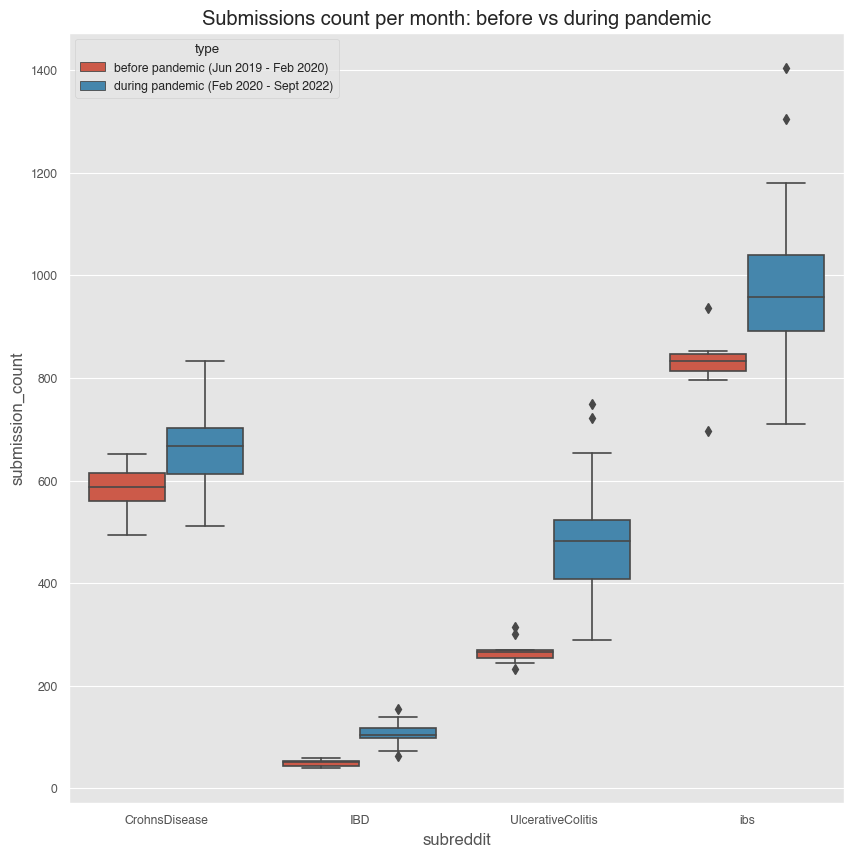

In [19]:
fig, ax1 = plt.subplots(figsize=(10,10))
sns.boxplot(data=result, x='subreddit', y='submission_count', hue='type', ax=ax1)
ax1.set_title('Submissions count per month: before vs during pandemic')
plt.show();

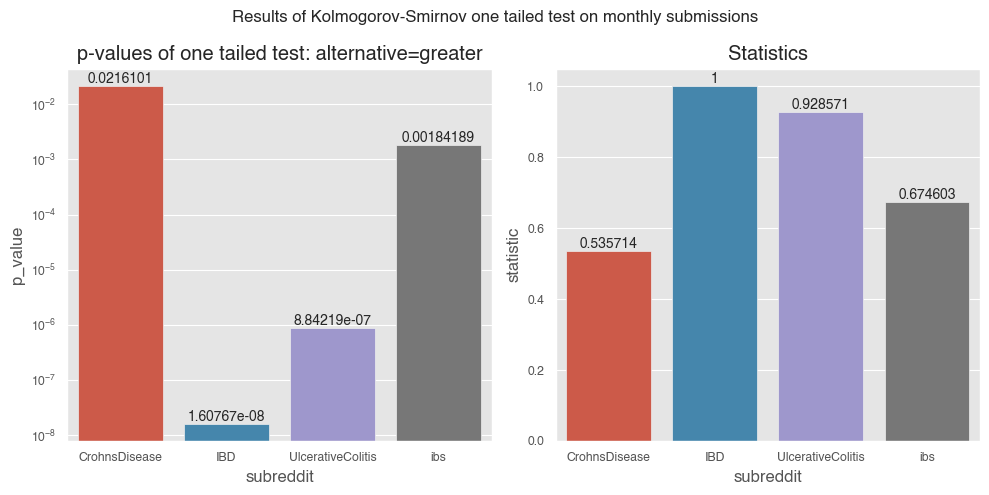

In [20]:
fig, [ax1, ax2] = plt.subplots(figsize=(10,5), ncols=2)
plt.suptitle('Results of Kolmogorov-Smirnov one tailed test on monthly submissions')
sns.barplot(data=p_values, x='subreddit', y='p_value', log=True, ax=ax1)
ax1.bar_label(ax1.containers[0])
ax1.set_title('p-values of one tailed test: alternative=greater')
sns.barplot(data=statistics, x='subreddit', y='statistic', ax=ax2)
ax2.bar_label(ax2.containers[0])
ax2.set_title('Statistics')
plt.tight_layout()
plt.show();

### Test 2꞉ Negatives count with Vader꞉
**before pandemic vs after pandemic**

In [21]:
df_submissions['label'] = df_submissions.compound.apply(lambda x: is_positive(x))

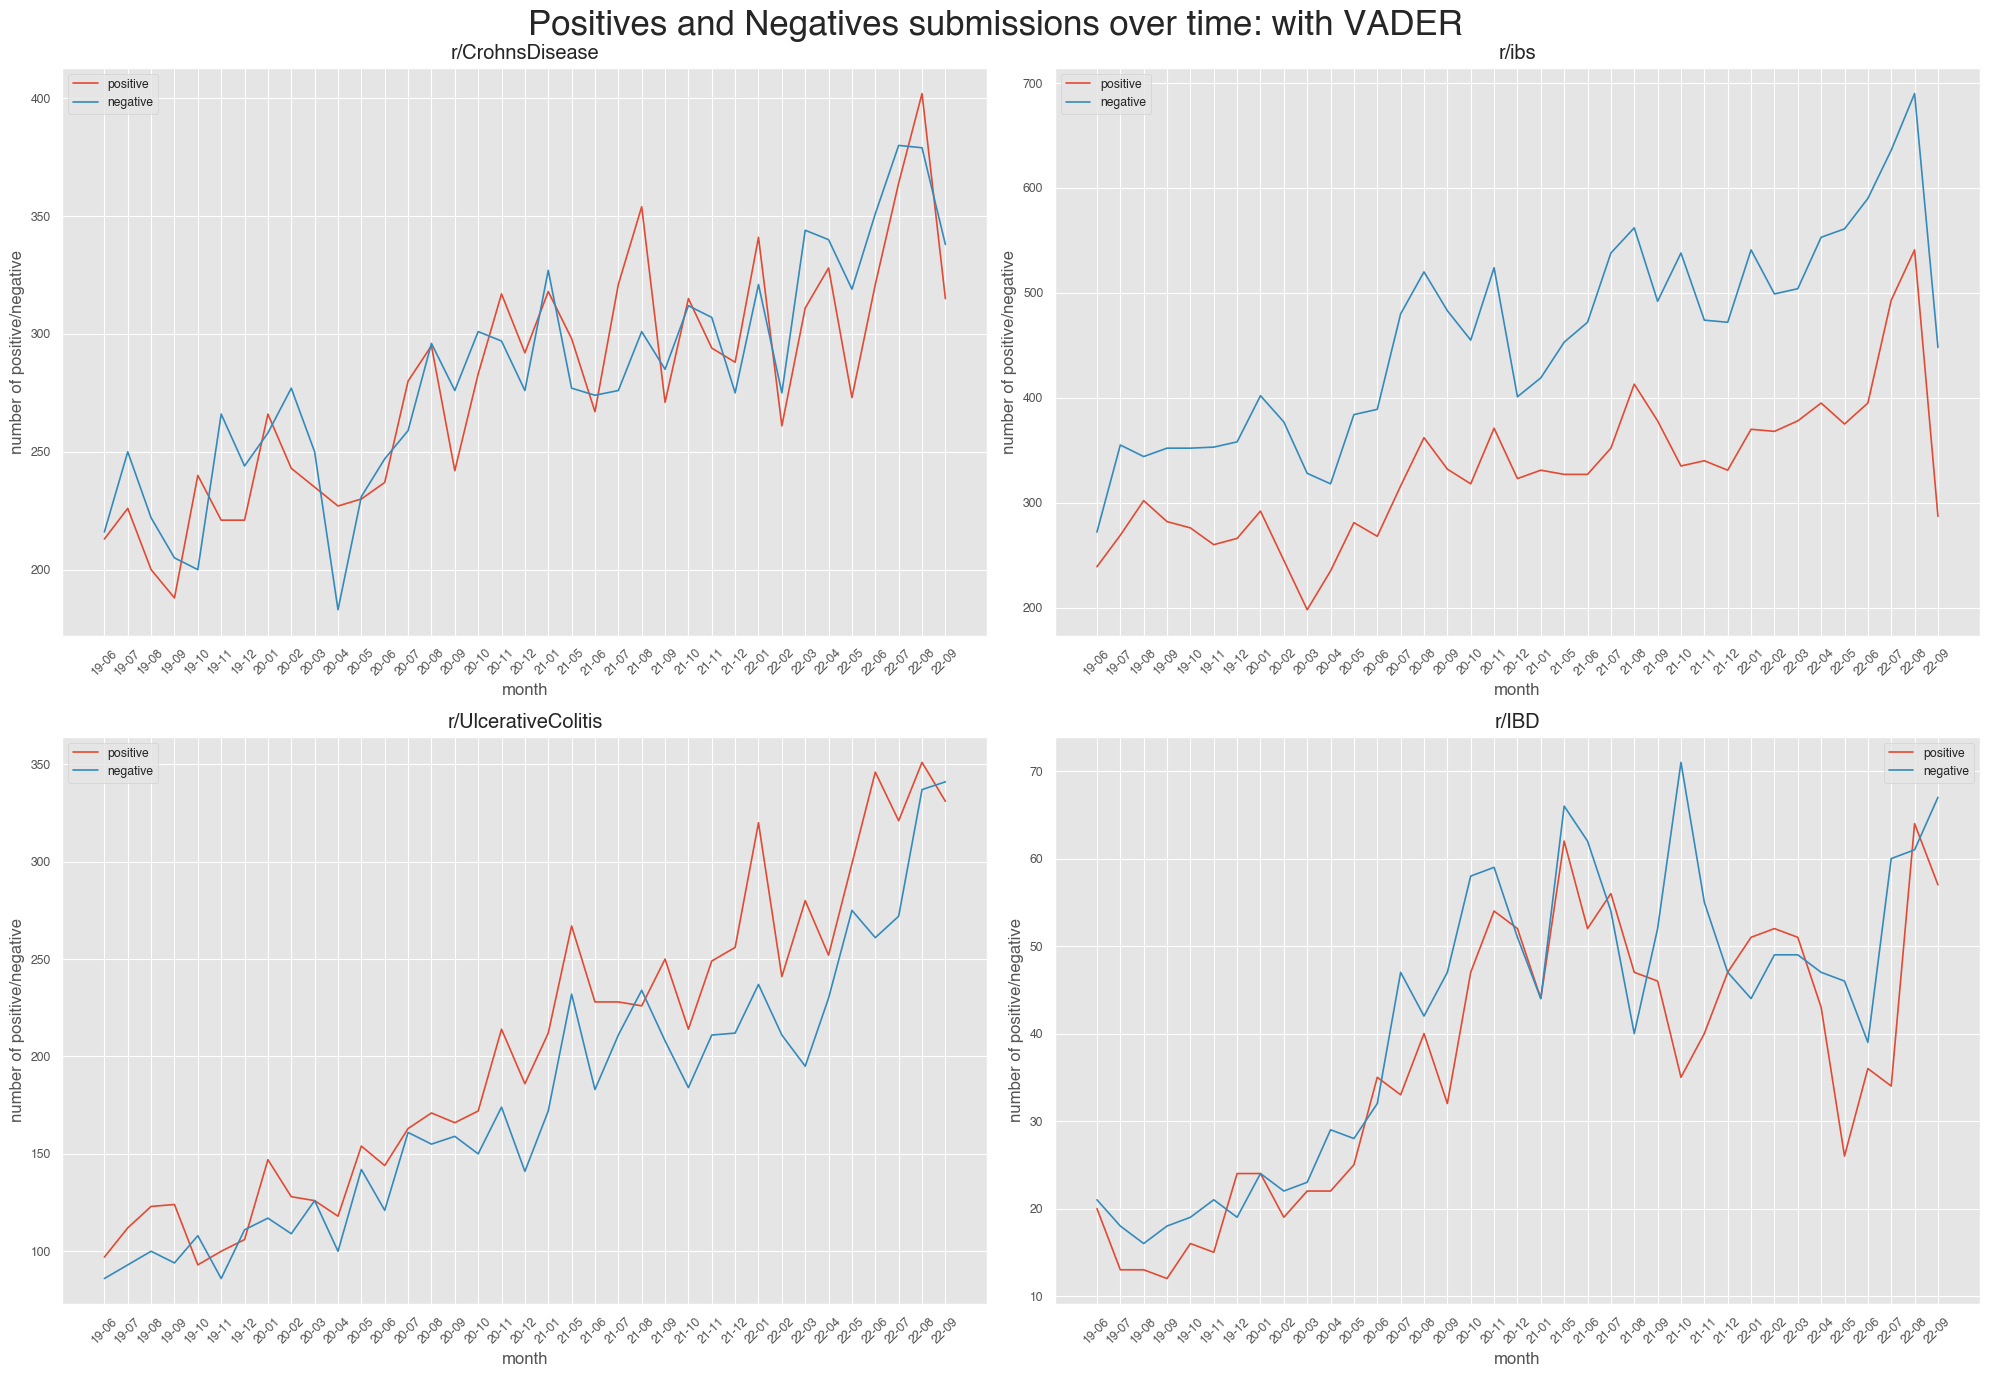

In [22]:
p = df_submissions[df_submissions['label'] == 1]
n = df_submissions[df_submissions['label'] == -1]

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20,14), ncols=2, nrows=2)
plt.suptitle('Positives and Negatives submissions over time: with VADER', fontsize=25)

ax1.set_title('r/CrohnsDisease')
ax1.set_xlabel('month')
ax1.set_ylabel('number of positive/negative')
cr_p = p[p['subreddit'] == 'CrohnsDisease'].groupby('created').count().reset_index()
cr_n = n[n['subreddit'] == 'CrohnsDisease'].groupby('created').count().reset_index()
sns.lineplot(x=cr_p.created, y=cr_p.id, ax=ax1, label='positive')
sns.lineplot(x=cr_n.created, y=cr_n.id, ax=ax1, label='negative')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

ax2.set_title('r/ibs')
ax2.set_xlabel('month')
ax2.set_ylabel('number of positive/negative')
ibs_p = p[p['subreddit'] == 'ibs'].groupby('created').count().reset_index()
ibs_n = n[n['subreddit'] == 'ibs'].groupby('created').count().reset_index()
sns.lineplot(x=ibs_p.created, y=ibs_p.id, ax=ax2, label='positive')
sns.lineplot(x=ibs_n.created, y=ibs_n.id, ax=ax2, label='negative')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

ax3.set_title('r/UlcerativeColitis')
ax3.set_xlabel('month')
ax3.set_ylabel('number of positive/negative')
ulc_p = p[p['subreddit'] == 'UlcerativeColitis'].groupby('created').count().reset_index()
ulc_n = n[n['subreddit'] == 'UlcerativeColitis'].groupby('created').count().reset_index()
sns.lineplot(x=ibs_p.created, y=ulc_p.id, ax=ax3, label='positive')
sns.lineplot(x=ibs_n.created, y=ulc_n.id, ax=ax3, label='negative')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

ax4.set_title('r/IBD')
ax4.set_xlabel('month')
ax4.set_ylabel('number of positive/negative')
ibd_p = p[p['subreddit'] == 'IBD'].groupby('created').count().reset_index()
ibd_n = n[n['subreddit'] == 'IBD'].groupby('created').count().reset_index()
sns.lineplot(x=ibs_p.created, y=ibd_p.id, ax=ax4, label='positive')
sns.lineplot(x=ibs_n.created, y=ibd_n.id, ax=ax4, label='negative')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show();

In [31]:
df_sub_neg_labels = df_submissions[df_submissions['label'] == -1].groupby(['created', 'subreddit']).count().reset_index()

In [32]:
df_sub_neg_labels = df_submissions[df_submissions['label'] == -1].groupby(['created', 'subreddit']).count().reset_index()

dfs = []
p_values = []
statistics = []
for sr in subreddits:
    # Before Pandemic (From Jun 2019 to Feb 2020)
    a = df_sub_neg_labels[(df_sub_neg_labels['subreddit'] == sr) & (df_sub_neg_labels['created'] <= '20-02')]
    # During Pandemic (From Feb 2020 to Sep 2022)
    b = df_sub_neg_labels[(df_sub_neg_labels['subreddit'] == sr) & (df_sub_neg_labels['created'] > '20-02')]
    
    a['type'] = 'Before pandemic (Jun 2019 - Feb 2020)'
    b['type'] = 'After pandemic (Feb 2020 - Sept 2022)'
    
    dfsr = pd.concat([a, b])
    dfsr['subreddit'] = sr
    dfs.append(dfsr)
                                                                    
    p_values.append((stats.kstest(a.id, b.id, alternative='greater').pvalue, sr))
    statistics.append((stats.kstest(a.id, b.id, alternative='greater').statistic, sr))
       
    print(colored(f'\nSubreddit: {sr}', color='blue'))
    print('Period: before pandemic (Jun 2019 - Feb 2020) vs during pandemic (Feb 2020 - Sept 2022)')
    print(stats.kstest(a.id, b.id, alternative='greater'))

p_values = pd.DataFrame(p_values, columns=['p_value', 'subreddit'])
statistics = pd.DataFrame(statistics, columns=['statistic', 'subreddit'])

result = pd.DataFrame()
for df in dfs:
    result = pd.concat([result, df])

result.rename(columns={'id': 'number_of_negatives'}, inplace=True)


Subreddit: CrohnsDisease
Period: before pandemic (Jun 2019 - Feb 2020) vs during pandemic (Feb 2020 - Sept 2022)
KstestResult(statistic=0.7103174603174603, pvalue=0.00041968232114145875)

Subreddit: IBD
Period: before pandemic (Jun 2019 - Feb 2020) vs during pandemic (Feb 2020 - Sept 2022)
KstestResult(statistic=0.9642857142857143, pvalue=8.038351295565193e-08)

Subreddit: UlcerativeColitis
Period: before pandemic (Jun 2019 - Feb 2020) vs during pandemic (Feb 2020 - Sept 2022)
KstestResult(statistic=0.9642857142857143, pvalue=8.038351295565193e-08)

Subreddit: ibs
Period: before pandemic (Jun 2019 - Feb 2020) vs during pandemic (Feb 2020 - Sept 2022)
KstestResult(statistic=0.8214285714285714, pvalue=1.775671801190351e-05)


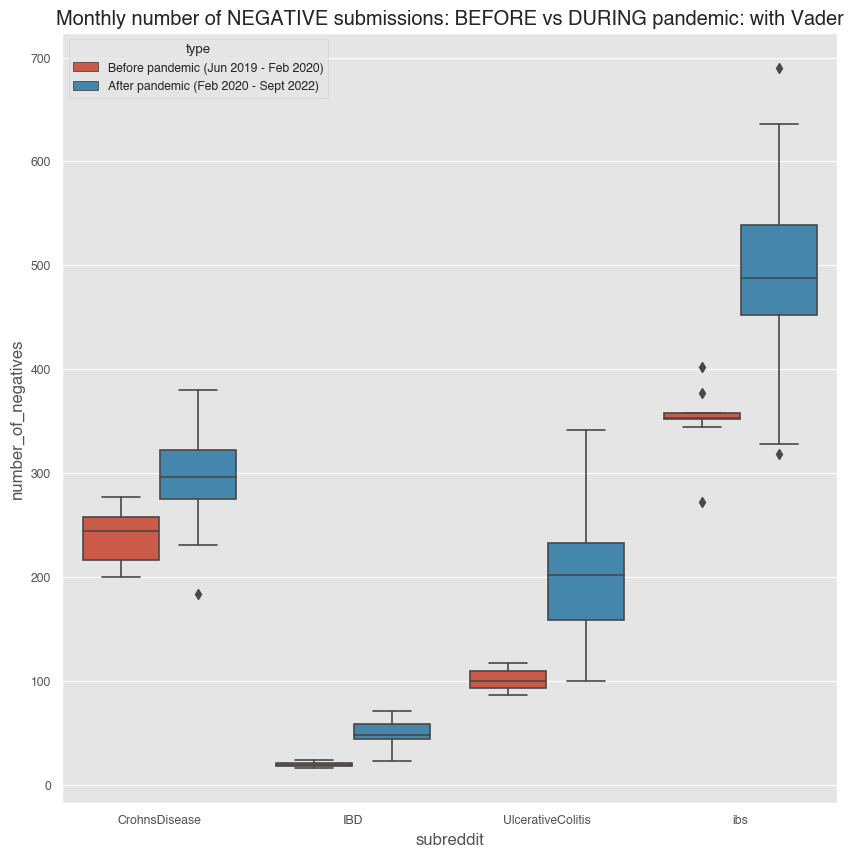

In [34]:
fig, ax1 = plt.subplots(figsize=(10,10))

ax1.set_title('Monthly number of NEGATIVE submissions: BEFORE vs DURING pandemic: with Vader')
ax1.set_ylabel('Montlhy average compound')

sns.boxplot(data=result, y='number_of_negatives', x='subreddit', hue='type', ax=ax1)
plt.show();

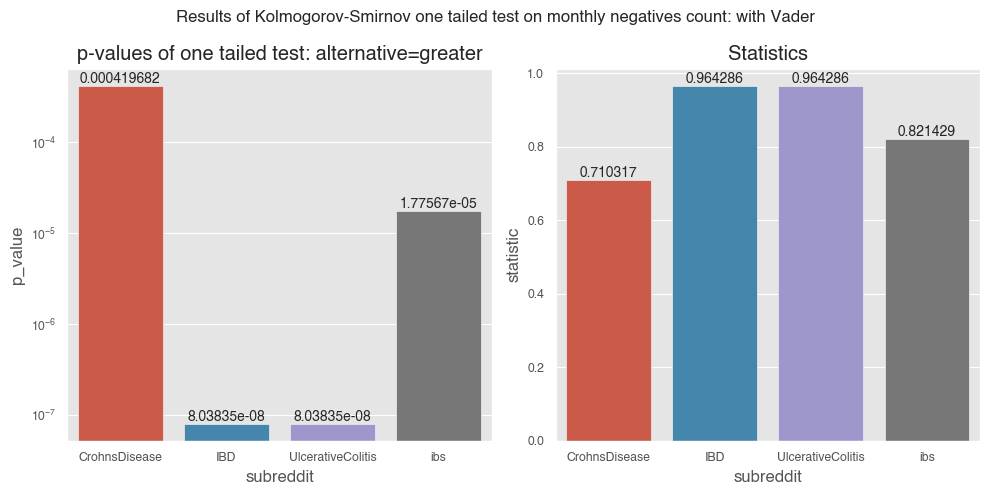

In [35]:
fig, [ax1, ax2] = plt.subplots(figsize=(10,5), ncols=2)
plt.suptitle('Results of Kolmogorov-Smirnov one tailed test on monthly negatives count: with Vader')

sns.barplot(data=p_values, x='subreddit', y='p_value', log=True, ax=ax1)
ax1.bar_label(ax1.containers[0])
ax1.set_title('p-values of one tailed test: alternative=greater')

sns.barplot(data=statistics, x='subreddit', y='statistic', ax=ax2)
ax2.bar_label(ax2.containers[0])
ax2.set_title('Statistics')

plt.tight_layout()
plt.show();

In [36]:
sentiments = []
all_sentiments = []
for post in tqdm(df_submissions.title_and_body, desc='Analyzing with roBERTa'):
    encoded_post = tokenizer(post, return_tensors='pt', max_length=256, truncation=True)
    output = model(**encoded_post)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    sentiments.append(labels[np.argmax(scores)])
    
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    dict_rob = {}
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        dict_rob[l] = np.round(float(s), 4)
        
    all_sentiments.append(dict_rob)

Analyzing with roBERTa:   0%|          | 0/78125 [00:00<?, ?it/s]

In [37]:
sentiments_roberta = map(convert_label, sentiments)
sentiments_roberta = list(sentiments_roberta)
df_submissions['roberta'] = all_sentiments
df_submissions['label_roberta'] = sentiments_roberta

In [38]:
a = pd.DataFrame({
    'label': df_submissions.label_roberta,
    'model': 'roberta'
})

b = pd.DataFrame({
    'label': df_submissions.label,
    'model': 'vader'
})

res = pd.concat([a, b])

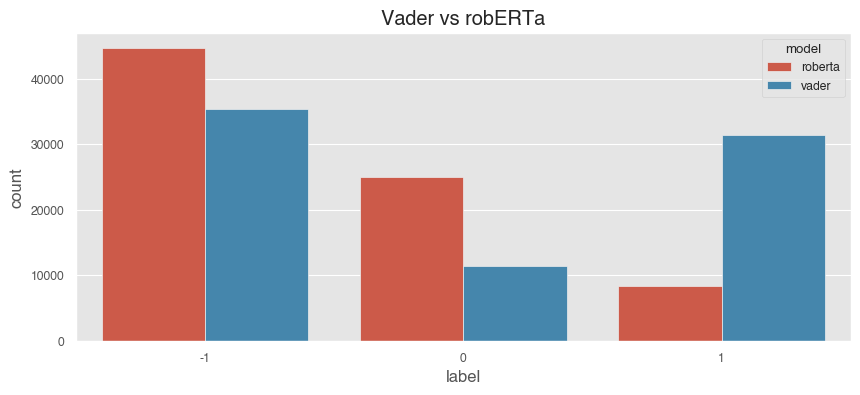

In [39]:
fig, ax = plt.subplots(figsize=(10,4))

ax.set_title('Vader vs robERTa')
sns.countplot(data=res, x='label', hue='model')

plt.show();

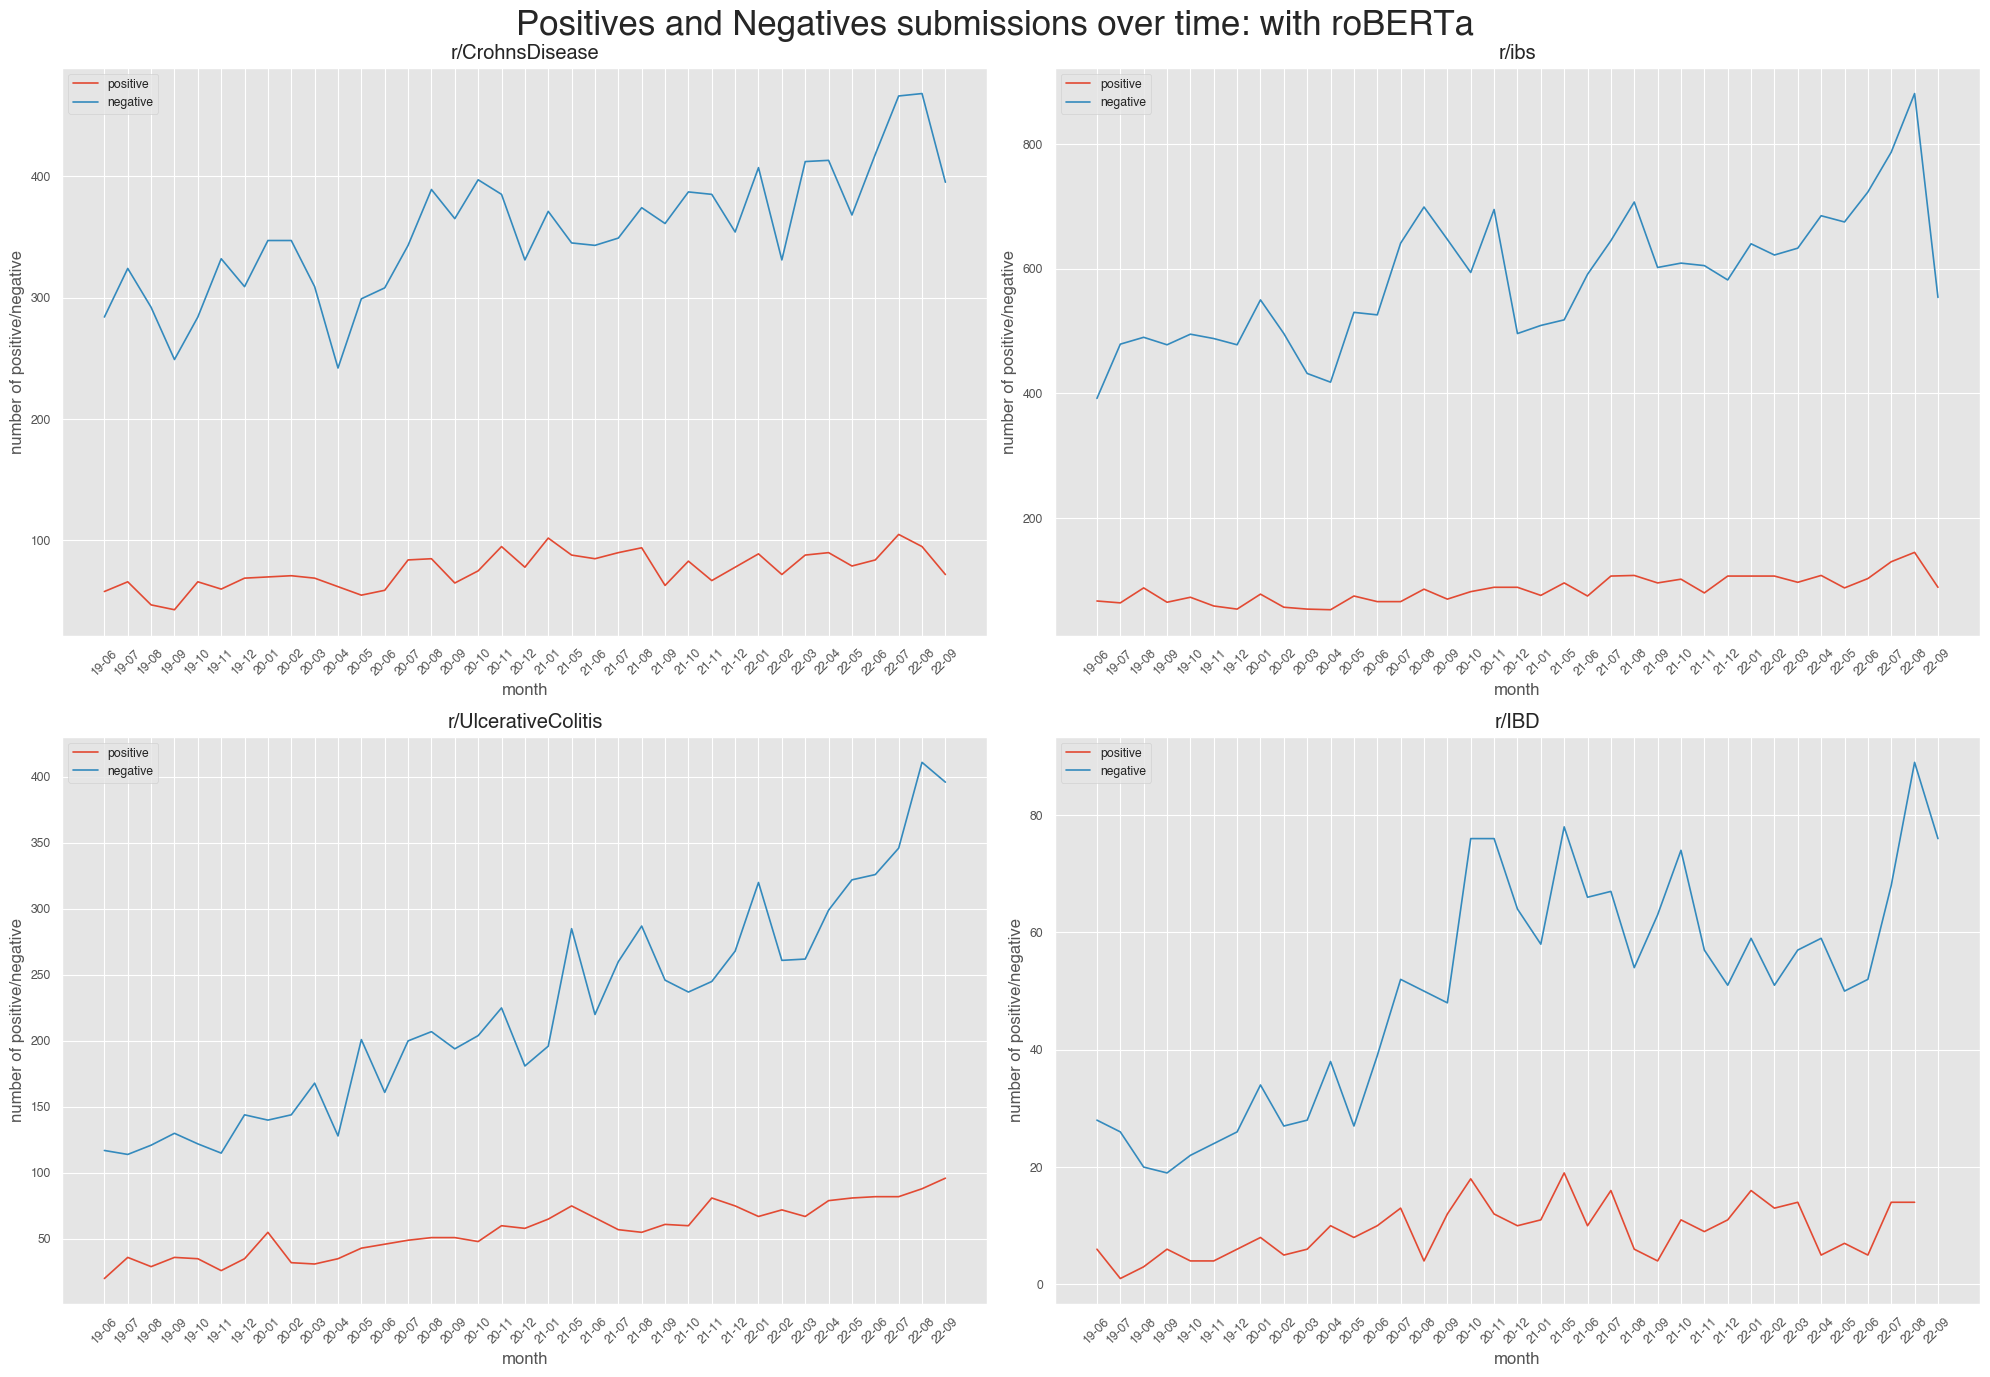

In [42]:
p = df_submissions[df_submissions['label_roberta'] == 1]
n = df_submissions[df_submissions['label_roberta'] == -1]

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20,14), ncols=2, nrows=2)

plt.suptitle('Positives and Negatives submissions over time: with roBERTa', fontsize=25)

ax1.set_title('r/CrohnsDisease')
ax1.set_xlabel('month')
ax1.set_ylabel('number of positive/negative')
cr_p = p[p['subreddit'] == 'CrohnsDisease'].groupby('created').count().reset_index()
cr_n = n[n['subreddit'] == 'CrohnsDisease'].groupby('created').count().reset_index()
sns.lineplot(x=cr_p.created, y=cr_p.id, ax=ax1, label='positive')
sns.lineplot(x=cr_n.created, y=cr_n.id, ax=ax1, label='negative')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

ax2.set_title('r/ibs')
ax2.set_xlabel('month')
ax2.set_ylabel('number of positive/negative')
ibs_p = p[p['subreddit'] == 'ibs'].groupby('created').count().reset_index()
ibs_n = n[n['subreddit'] == 'ibs'].groupby('created').count().reset_index()
sns.lineplot(x=ibs_p.created, y=ibs_p.id, ax=ax2, label='positive')
sns.lineplot(x=ibs_n.created, y=ibs_n.id, ax=ax2, label='negative')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

ax3.set_title('r/UlcerativeColitis')
ax3.set_xlabel('month')
ax3.set_ylabel('number of positive/negative')
ulc_p = p[p['subreddit'] == 'UlcerativeColitis'].groupby('created').count().reset_index()
ulc_n = n[n['subreddit'] == 'UlcerativeColitis'].groupby('created').count().reset_index()
sns.lineplot(x=ibs_p.created, y=ulc_p.id, ax=ax3, label='positive')
sns.lineplot(x=ibs_n.created, y=ulc_n.id, ax=ax3, label='negative')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

ax4.set_title('r/IBD')
ax4.set_xlabel('month')
ax4.set_ylabel('number of positive/negative')
ibd_p = p[p['subreddit'] == 'IBD'].groupby('created').count().reset_index()
ibd_n = n[n['subreddit'] == 'IBD'].groupby('created').count().reset_index()
sns.lineplot(x=ibs_p.created, y=ibd_p.id, ax=ax4, label='positive')
sns.lineplot(x=ibs_n.created, y=ibd_n.id, ax=ax4, label='negative')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show();

In [45]:
df_sub_neg_labels = df_submissions[df_submissions['label_roberta'] == -1].groupby(['created', 'subreddit']).count().reset_index()

dfs = []
p_values = []
statistics = []
for sr in subreddits:
    # Before Pandemic (From Jun 2019 to Feb 2020)
    a = df_sub_neg_labels[(df_sub_neg_labels['subreddit'] == sr) & (df_sub_neg_labels['created'] <= '20-02')]
    # During Pandemic (From Feb 2020 to Sep 2022)
    b = df_sub_neg_labels[(df_sub_neg_labels['subreddit'] == sr) & (df_sub_neg_labels['created'] > '20-02')]
    
    a['type'] = 'Before pandemic (Jun 2019 - Feb 2020)'
    b['type'] = 'During pandemic (Feb 2020 - Sept 2022)'
    
    dfsr = pd.concat([a, b])
    dfsr['subreddit'] = sr
    dfs.append(dfsr)
    
    print(colored(f'\nSubreddit: {sr}', color='blue'))
    print('Period: before pandemic (Jun 2019 - Feb 2020) vs during pandemic (Feb 2020 - Sept 20220)')
    print(stats.kstest(a.id, b.id, alternative='greater'))
    
    p_values.append((stats.kstest(a.id, b.id, alternative='greater').pvalue, sr))
    statistics.append((stats.kstest(a.id, b.id, alternative='greater').statistic, sr))
          
p_values = pd.DataFrame(p_values, columns=['p_value', 'subreddit'])
statistics = pd.DataFrame(statistics, columns=['statistic', 'subreddit'])

result_rob = pd.DataFrame()
for df in dfs:
    result_rob = pd.concat([result_rob, df])

result_rob.rename(columns={'id': 'number_of_negatives'}, inplace=True)


Subreddit: CrohnsDisease
Period: before pandemic (Jun 2019 - Feb 2020) vs during pandemic (Feb 2020 - Sept 20220)
KstestResult(statistic=0.6785714285714286, pvalue=0.0006643616962271676)

Subreddit: IBD
Period: before pandemic (Jun 2019 - Feb 2020) vs during pandemic (Feb 2020 - Sept 20220)
KstestResult(statistic=0.9285714285714286, pvalue=4.4210932125608565e-07)

Subreddit: UlcerativeColitis
Period: before pandemic (Jun 2019 - Feb 2020) vs during pandemic (Feb 2020 - Sept 20220)
KstestResult(statistic=0.9642857142857143, pvalue=8.038351295565193e-08)

Subreddit: ibs
Period: before pandemic (Jun 2019 - Feb 2020) vs during pandemic (Feb 2020 - Sept 20220)
KstestResult(statistic=0.7817460317460317, pvalue=6.941116343720545e-05)


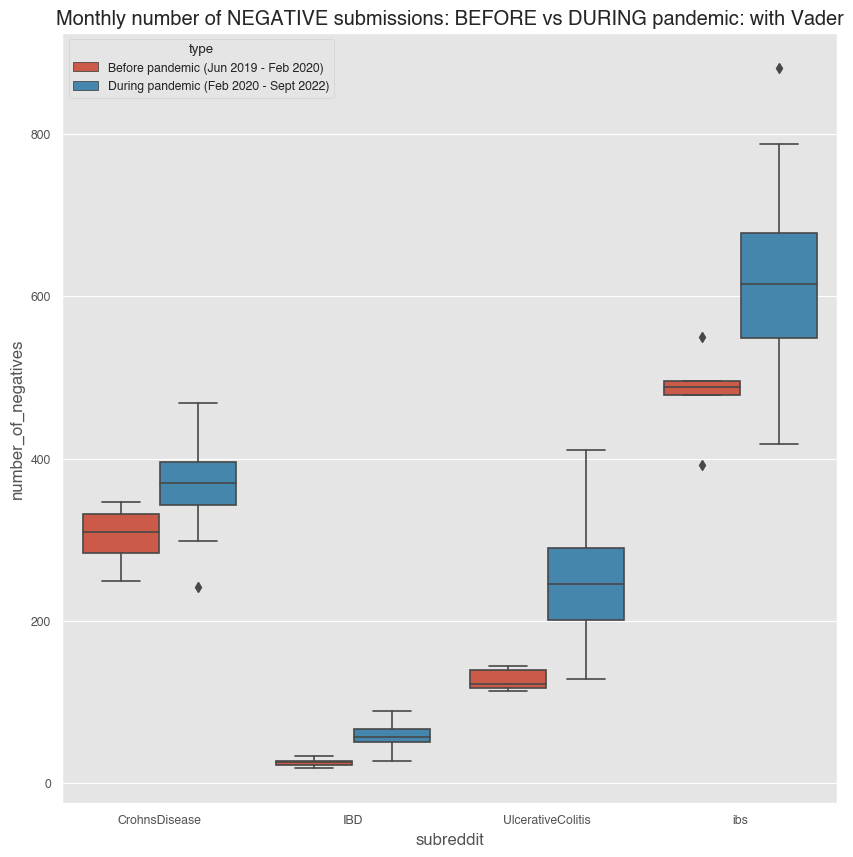

In [47]:
fig, ax1 = plt.subplots(figsize=(10,10))

ax1.set_title('Monthly number of NEGATIVE submissions: BEFORE vs DURING pandemic: with Vader')
sns.boxplot(data=result_rob, y='number_of_negatives', x='subreddit', hue='type', ax=ax1)

plt.show();

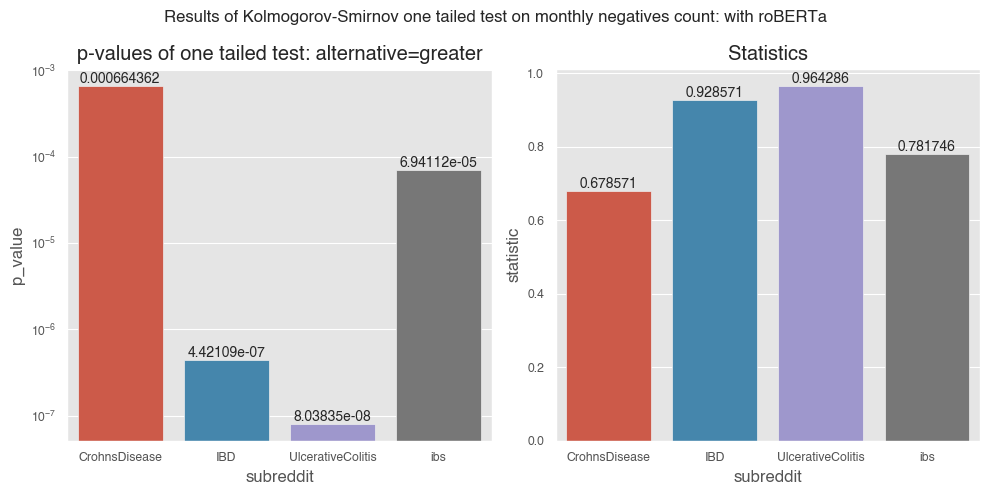

In [48]:
fig, [ax1, ax2] = plt.subplots(figsize=(10,5), ncols=2)

plt.suptitle('Results of Kolmogorov-Smirnov one tailed test on monthly negatives count: with roBERTa')

sns.barplot(data=p_values, x='subreddit', y='p_value', log=True, ax=ax1)
ax1.bar_label(ax1.containers[0])
ax1.set_title('p-values of one tailed test: alternative=greater')

sns.barplot(data=statistics, x='subreddit', y='statistic', ax=ax2)
ax2.bar_label(ax2.containers[0])
ax2.set_title('Statistics')

plt.tight_layout()
plt.show();

### Test 4꞉ Negativity in covid related posts

In [49]:
covid_keywords = [
    "Pandemic",
    "pandemic",
    "coronavirus" ,
    "CORONAVIRUS",
    "Coronavirus",
    "COVID-19",
    "COVID19",
    "COVID",
    "COVID 19",
    "covid-19",
    "covid19",
    "covid",
    "covid 19",
    "Covid-19",
    "Covid19",
    "Covid",
    "Covid 19",
    "Vaccine",
    "vaccine"
    "SARS-COV-2",
    "SARS COV-2",
    "SARS-COV2",
    "SARS-COV 2",
    "SARS COV"
]

disease_keywords = [
    'crohn',
    'ibd',
    'ibs',
    'ulcerative',
    'colitis',
]

patterns = []
for k in covid_keywords:
    for dk in disease_keywords:
        s1 = f'{dk}.*{k}'
        s2 = f'{k}.*{dk}'
        patterns.append(s1)
        patterns.append(s2)

In [50]:
regxpr = '|'.join([f'{p}' for p in patterns])
simple_pattern = '|'.join([f'{p}' for p in covid_keywords])

In [54]:
df_sub_filtered = df_submissions[df_submissions.title_and_body.str.contains(simple_pattern)]
df_sub_filtered.shape[0]

3024

In [56]:
df_filt_neg = df_sub_filtered[df_sub_filtered['label_roberta'] == -1]

# Compare IBD vs ibs
df_ibd = df_filt_neg[(df_filt_neg['subreddit'] == 'IBD') | (df_filt_neg['subreddit'] == 'CrohnsDisease') | (df_filt_neg['subreddit'] == 'UlcerativeColitis') ]
df_ibs = df_filt_neg[(df_filt_neg['subreddit'] == 'ibs')]
df_ibd = df_ibd.groupby('created').count().reset_index()
df_ibs = df_ibs.groupby('created').count().reset_index()

### Keep data from March 2020
df_ibd = df_ibd[df_ibd['created'] >= '20-03']
df_ibs = df_ibs[df_ibs['created'] >= '20-03']

print(colored('\nTwo groups compared: IBD vs IBS', color='blue'))
print(stats.kstest(df_ibd.id, df_ibs.id), '\n')

df_ibs['type'] = 'IBS (Irritable bowel syndrome) [r/ibs]'
df_ibd['type'] = 'IBD (Inflammatory bowel disease) [r/CrohnsDisease, r/UlcerativeColitis, r/IBD]'

result = pd.concat([df_ibs, df_ibd])
result.rename(columns={'id': 'number_of_negatives'}, inplace=True)


Two groups compared: IBD vs IBS
KstestResult(statistic=0.7142857142857143, pvalue=3.7143457596749274e-07) 

